In [47]:
# Necessary imports
import os
import json
import copy

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


# Data Exploration
Only basic data exploration was performed, the goal mainly being to see the distribution of data and the number of missing values for each feature

In [21]:
# paths
data_dir = r'data'
data_pth = os.path.join(data_dir, r'Almond.csv')

data = pd.read_csv(data_pth)

# Drop the first (index) column
data = data.drop(data.columns[0], axis=1)

print("Number of rows: ", data.shape[0])
print("Number of cols: ", data.shape[1])
print("Columns: ", [col for col in data.columns])
print("==========================================")

print("Num unique types: ", data['Type'].nunique())
print("Unique types:\n", data['Type'].value_counts())

# print number of null values per column
print("==========================================")
print("Number of null values per column:")
print(data.isnull().sum())


Number of rows:  2803
Number of cols:  13
Columns:  ['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness', 'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)', 'Type']
Num unique types:  3
Unique types:
 Type
SANORA     943
MAMRA      933
REGULAR    927
Name: count, dtype: int64
Number of null values per column:
Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64


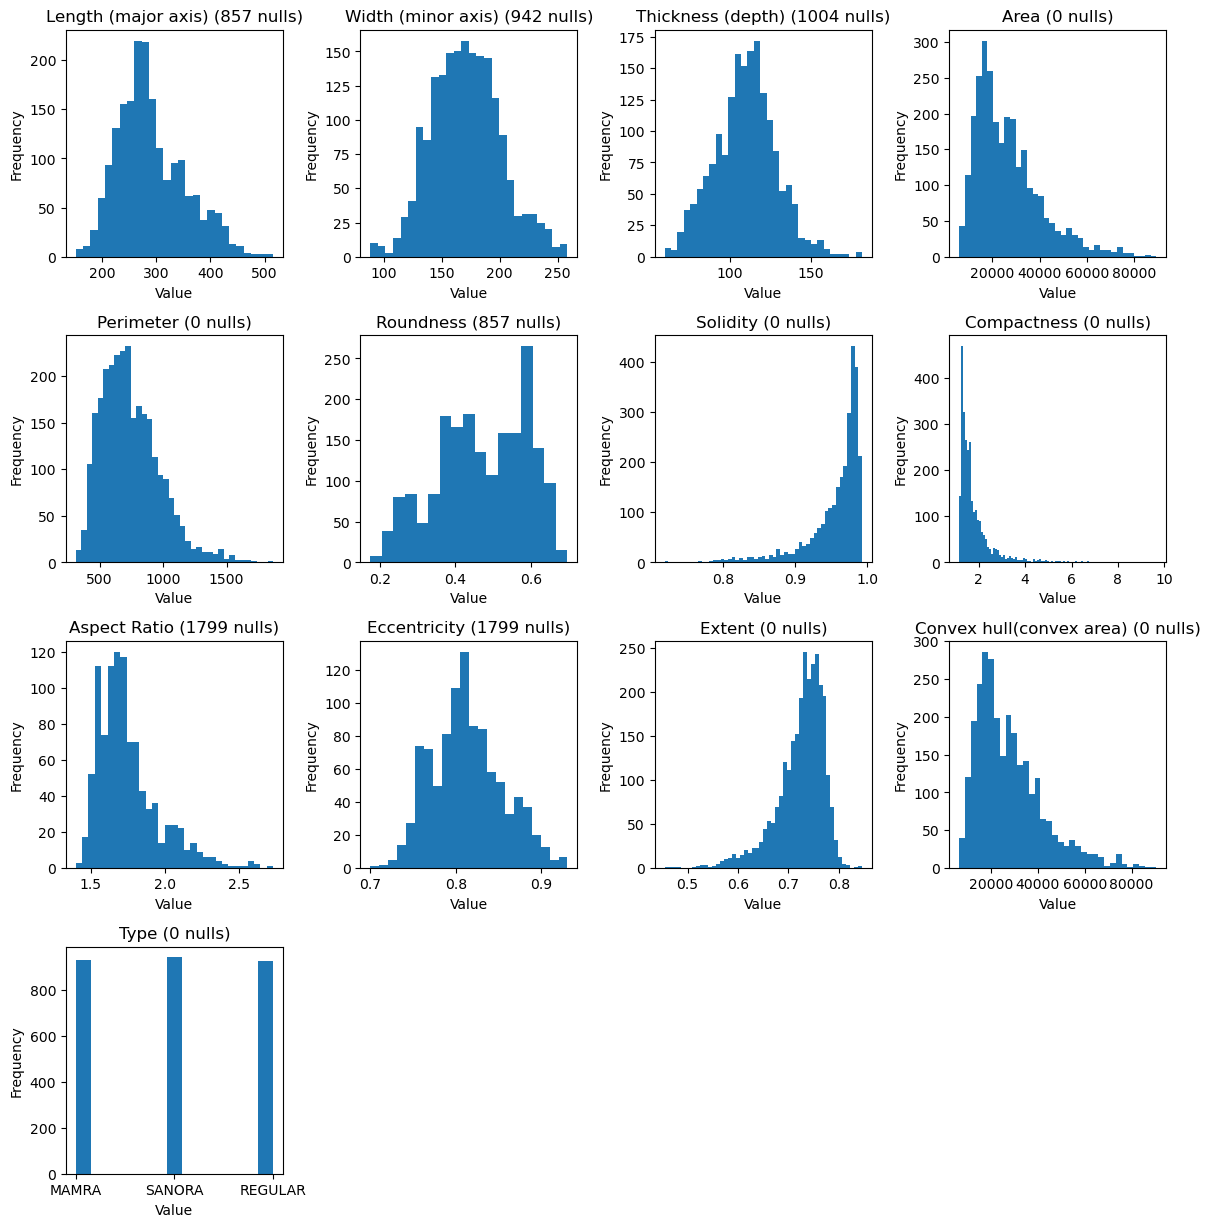

In [22]:
# Plot a subplot histogram for each column, ignore null values
fig, axs = plt.subplots(5, 4, figsize=(12, 15))

flat_axs = axs.flatten()
for i, col in enumerate(data.columns):
    non_null_data = data[col].dropna()
    num_null = data[col].isnull().sum()
    flat_axs[i].hist(non_null_data, bins='auto')
    flat_axs[i].set_title(col + f' ({num_null} nulls)')
    flat_axs[i].set_xlabel('Value')
    flat_axs[i].set_ylabel('Frequency')
    

# hide the unused subplots
for i in range(data.shape[1], len(flat_axs)):
    fig.delaxes(flat_axs[i])

plt.tight_layout()
plt.show()


# Data Preparation

In [31]:
# Functions and classes related to data preprocessing

def data_split_basic(data, train_p=0.8):
    """ Splits data into training and testing sets. """
    # Shuffle the data
    data = data.sample(frac=1).reset_index(drop=True)
    
    # Split the data
    train = data.iloc[:int(train_p * len(data)), :]
    test = data.iloc[int(train_p * len(data)):, :]
    
    return train, test

def calculate_data_scale(train):
    """ Calculates scaling metrics for training data. """
    # Calculate scaling parameters
    scaling_params = train.describe().loc[['mean', 'std', 'min', 'max'], :]    
    return scaling_params

def save_scaling_params(scaling_params, pth):
    scaling_params.to_json(pth, indent=4)

def save_datasets(train, test, dir):
    """ Saves training and testing datasets to a directory. File names are 'train.csv' and 'test.csv'. """
    if not os.path.exists(os.path.join(data_dir, dir)):
        os.makedirs(os.path.join(data_dir, dir), exist_ok=True) # Create the directory if it doesn't exist
    train_pth = None
    if train is not None:
        train_pth = os.path.join(data_dir, dir, 'train.csv')
        train.to_csv(train_pth, index=False)
    
    test_pth = None
    if test is not None:
        test_pth = os.path.join(data_dir, dir, 'test.csv')
        test.to_csv(test_pth, index=False)
    
    return train_pth, test_pth

def mean_imputation(data):
    """Imputes missing values with the mean of numeric columns only."""
    numeric_columns = data.select_dtypes(include='number')
    return data.fillna(numeric_columns.mean())


In [40]:
# Reread the data
data = pd.read_csv(data_pth)

# Drop the first (index) column
data = data.drop(data.columns[0], axis=1)

# Drop the Eccentricity and Aspect Ratio columns as they have have more than 50% missing values
data = data.drop(['Eccentricity', 'Aspect Ratio'], axis=1)

# Perform mean imputation
data = mean_imputation(data)
# See if any columns contain null values
print("Contains null values: ", data.isnull().values.any())

# Perform a basic split
train, test = data_split_basic(data, train_p=0.9) # 90% training, 10% testing
print(f"Training data shape: {train.shape}")
print(f"Testing data shape: {test.shape}")
scaling_params = calculate_data_scale(train) # Calculate scaling parameters on the training data
train_pth, test_pth = save_datasets(train, test, "basic")
save_scaling_params(scaling_params, os.path.join(data_dir, 'basic', 'scaling_params.json'))

Contains null values:  False
Training data shape: (2522, 11)
Testing data shape: (281, 11)


# Code Related To Model Training With a Sinle Optimizer
## Structure:
1. Classes and Functions
2. Hyperparameter Tuning
3. Runs on Test Set

In [42]:
class AlmondDataset(Dataset):
    def __init__(self, data_dir, is_train=True, transform=None):
        target_file = 'train.csv' if is_train else 'test.csv'
        path = os.path.join(data_dir, target_file)

        # Convert the label to a numerical value
        self.label_map = {
            'MAMRA': 0,
            'REGULAR': 1,
            'SANORA': 2,
        }
        self.data = pd.read_csv(path)

        if not all(self.data["Type"].isin(self.label_map.keys())):
            raise ValueError("Invalid label in the dataset")

        self.labels = self.data['Type'].map(self.label_map).values
        self.labels = torch.tensor(self.labels, dtype=torch.long) # convert to tensor
        self.data = self.data.drop(columns=['Type'])

        self.transform = transform
        # eagerly transform the data
        if self.transform:
            self.data = self.transform(self.data)

        # convert data to tensor
        self.data = torch.tensor(self.data.values, dtype=torch.float)


    def num_classes(self):
        return len(self.label_map)
    
    def num_features(self):
        return self.data.shape[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def read_scaling_params(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)


def scale_to_range(val, unscaled_min, unscaled_max, scaled_min, scaled_max):
    return (val - unscaled_min) / (unscaled_max - unscaled_min) * (scaled_max - scaled_min) + scaled_min


class Standardize:
    def __init__(self, scaling_params):
        self.scaling_params = scaling_params

    def __call__(self, sample):
        for col in sample.columns:
            if col not in self.scaling_params:
                continue
            sample[col] = (sample[col] - self.scaling_params[col]['mean'])
            sample[col] = sample[col] / self.scaling_params[col]['std']

        return sample


class ScaleToRange:
    def __init__(self, scaling_params, high, low):
        self.scaling_params = scaling_params
        self.high = high
        self.low = low

    def __call__(self, sample):
        for col in sample.columns:
            if col not in self.scaling_params:
                continue
            sample[col] = scale_to_range(sample[col], self.scaling_params[col]['min'], self.scaling_params[col]['max'], self.low, self.high)

        return sample


# Function to impute NaNs and nulls with 0
def impute(sample):
    sample.fillna(0, inplace=True)
    return sample


# Function to transform data by applying standardization and imputation
def transform(sample, scaling_params):
    sample = Standardize(scaling_params)(sample)
    sample = impute(sample) # This step should be unnecessary as we've already imputed the data, but left in for redundancy
    return sample


In [44]:
# A simple FFNN model that is made to be configurable
class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes, hl_sizes=[256, 256, 256, 256], 
                 use_bn=True, dropout_rate=0.0):
        """
        input_size: int, number of input features
        num_classes: int, number of output classes
        hl_sizes: list of ints, number of neurons in each hidden layer
        use_bn: bool, whether to use Batch Normalization
        dropout_rate: float, dropout rate (0.0 means no dropout)
        """
        super(SimpleNet, self).__init__()
        
        # Check that hl_sizes has at least one hidden layer size
        assert len(hl_sizes) > 0, "hl_sizes must have at least one hidden layer size"
        
        # Create layers dynamically based on the hl_sizes list
        self.layers = nn.ModuleList()
        self.use_bn = use_bn
        self.use_dropout = dropout_rate > 0.0
        self.dropout_rate = dropout_rate
        
        prev_size = input_size
        for hl_size in hl_sizes:
            self.layers.append(nn.Linear(prev_size, hl_size))
            if use_bn:
                self.layers.append(nn.BatchNorm1d(hl_size))
            self.layers.append(nn.ReLU(inplace=True))
            if self.use_dropout:
                self.layers.append(nn.Dropout(dropout_rate))
            prev_size = hl_size
        
        # Output layer
        self.out = nn.Linear(prev_size, num_classes)

    def forward(self, x):
        # Pass through all hidden layers
        for layer in self.layers:
            x = layer(x)
        
        # Output layer
        x = self.out(x)
        return x

    def get_num_params(self):
        """ Returns the total number of trainable parameters """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    

In [45]:
# Training function for one epoch using a single optimizer
def train_one_epoch(model, train_loader, criterion, optimizer, device, verbose=False):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        if verbose and batch_idx % 100 == 0:
            print(f'Batch {batch_idx+1}/{len(train_loader)}')
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()
    return running_loss / len(train_loader)


# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


# Function to initialize data objects
def get_data_objects(sub_dir, scaling_params):
    transform_fn = lambda sample: transform(sample, scaling_params)
    almonds_train = AlmondDataset(os.path.join('data', sub_dir),
                                  is_train=True, 
                                  transform=transform_fn)
    almonds_test = AlmondDataset(os.path.join('data', sub_dir),
                                 is_train=False,
                                 transform=transform_fn)
    return almonds_train, almonds_test


# Function to initialize model, criterion, and optimizer
def initialize_model(input_size, num_classes, optimizer_config, device):
    model = SimpleNet(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()  # Loss function

    # Initialize optimizer based on the current configuration
    if 'SGD' in optimizer_config:
        optimizer = optim.SGD(model.parameters(), 
            lr=optimizer_config['SGD'].get('lr', 0.01), 
            momentum=optimizer_config['SGD'].get('momentum', 0.9), 
            weight_decay=optimizer_config['SGD'].get('weight_decay', 0.0)
        )
    elif 'Adam' in optimizer_config:
        optimizer = optim.Adam(model.parameters(), 
            lr=optimizer_config['Adam'].get('lr', 0.001),
            betas=(optimizer_config['Adam'].get('beta1', 0.9), optimizer_config['Adam'].get('beta2', 0.999)),
            weight_decay=optimizer_config['Adam'].get('weight_decay', 0.0)
        )
    elif 'Rprop' in optimizer_config:
        optimizer = optim.Rprop(model.parameters(), 
            lr=optimizer_config['Rprop'].get('lr', 0.01), 
            etas=optimizer_config['Rprop'].get('etas', (0.5, 1.2)), 
            step_sizes=optimizer_config['Rprop'].get('step_sizes', (1e-6, 50))
        )
    elif 'RMSprop' in optimizer_config:
        optimizer = optim.RMSprop(model.parameters(), 
            lr=optimizer_config['RMSprop'].get('lr', 0.01), 
            alpha=optimizer_config['RMSprop'].get('alpha', 0.99), 
            eps=optimizer_config['RMSprop'].get('eps', 1e-08), 
            weight_decay=optimizer_config['RMSprop'].get('weight_decay', 0.0), 
            momentum=optimizer_config['RMSprop'].get('momentum', 0.0), 
            centered=optimizer_config['RMSprop'].get('centered', False)
        )

    return model, criterion, optimizer

In [55]:
# Function to run K-Fold Cross-Validation with Early Stopping
def run_k_fold_cv(almonds_train, num_epochs, batch_size, optimizer_config, k_folds, device, patience=15, best_so_far=None, verbose=False):
    # Initialize K-Fold Cross-Validation with shuffling
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    fold_accuracies = []  # List to store best validation accuracies for each fold
    run_val_accuracies = [[] for _ in range(k_folds)]  # List to store validation accuracies for each epoch per fold
    run_train_losses = [[] for _ in range(k_folds)]  # List to store training losses for each epoch per fold
    
    # Loop over each fold
    for fold, (train_ids, val_ids) in enumerate(kfold.split(almonds_train)):
        if verbose:
            print(f'Fold {fold+1}/{k_folds}')
        
        # Create training and validation subsets based on the fold split
        train_subset = Subset(almonds_train, train_ids)
        val_subset = Subset(almonds_train, val_ids)
        
        # Create data loaders for training and validation
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True) # Using drop_last to ensure batch size consistency
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Initialize the model, loss function (criterion), and optimizer
        model, criterion, optimizer = initialize_model(almonds_train.num_features(), almonds_train.num_classes(), optimizer_config, device)

        best_val_accuracy = 0.0  # Track the best validation accuracy in the current fold
        epochs_no_improve = 0  # Counter for epochs without improvement
        
        # Training loop for the specified number of epochs
        for epoch in range(num_epochs):
            # Train the model for one epoch and get the training loss
            loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
            # Evaluate the model on the validation set and get validation accuracy
            val_accuracy = evaluate(model, val_loader, device)
            # Store validation accuracy and training loss for current epoch
            run_val_accuracies[fold].append(val_accuracy)
            run_train_losses[fold].append(loss)
            
            if verbose:
                print(f'Fold {fold+1}, Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

            # Check if validation accuracy improved
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy  # Update best validation accuracy
                epochs_no_improve = 0  # Reset no-improvement counter
            else:
                epochs_no_improve += 1  # Increment no-improvement counter

            # Early stopping if validation accuracy doesn't improve for 'patience' epochs
            if epochs_no_improve >= patience:
                if verbose:
                    print(f'Early stopping at epoch {epoch+1} due to no improvement in {patience} epochs.')
                break  # Stop training for the current fold

        # Append the best validation accuracy for this fold
        fold_accuracies.append(best_val_accuracy)

        # Prune poor-performing runs if specified
        if best_so_far is not None and (best_val_accuracy < best_so_far - 5 or best_val_accuracy < 75.0): # These values were chosen emperically
            if verbose:
                print(f'Pruning run due to poor performance')
            break  # Exit early if performance is too low

    # Compute the average validation accuracy across all folds
    avg_val_accuracy = sum(fold_accuracies) / len(fold_accuracies)

    # Convert validation accuracies and training losses to dataframes for easier analysis
    run_val_accuracies_df = pd.DataFrame(run_val_accuracies).T
    run_val_accuracies_df.columns = [f'Fold {i+1}' for i in range(k_folds)]

    run_train_losses_df = pd.DataFrame(run_train_losses).T
    run_train_losses_df.columns = [f'Fold {i+1}' for i in range(k_folds)]

    # Return the average validation accuracy, per-fold accuracies, and dataframes
    return avg_val_accuracy, fold_accuracies, run_val_accuracies_df, run_train_losses_df


In [60]:
def search_best_hyperparameters(search_space, sub_dir='basic', k_folds=5):
    """
    Function to search for the best hyperparameter combination using K-Fold Cross-Validation.

    Args:
        search_space (list): List of configurations to evaluate.
        scaling_params_path (str): Path to the scaling parameters JSON file.
        sub_dir (str): Sub-directory for dataset loading.
        k_folds (int): Number of folds for K-Fold Cross-Validation.

    Returns:
        dict: Best hyperparameter configuration.
        float: Best average validation accuracy.
        list: List of results for each configuration, containing metrics and accuracies.
        pd.DataFrame: DataFrame containing validation accuracies across folds for the best configuration.
        pd.DataFrame: DataFrame containing training losses across folds for the best configuration.
    """
    # Read scaling parameters
    scaling_params = read_scaling_params(os.path.join('data', sub_dir, 'scaling_params.json'))

    # Initialize variables to track the best configuration and all results
    best_combination = None
    best_avg_val_accuracy = 0.0
    best_val_accuracies_df = None
    best_train_losses_df = None

    all_results = []  # List to store results for each configuration

    # Loop over all configurations in the search space
    for config_idx, config in enumerate(search_space):
        print(f"Running configuration: {config}")
        print(f"{config_idx+1}/{len(search_space)}")

        # Extract parameters from the current configuration
        num_epochs = config['epochs']
        batch_size = config['batch_size']
        optimizer_config = config['optimizer']

        # Get datasets based on the current configuration
        almonds_train, almonds_test = get_data_objects(sub_dir=sub_dir, scaling_params=scaling_params, batch_size=batch_size)

        # Set the device based on the batch size (CPU for small batch, GPU if available for larger batches)
        device = torch.device('cpu') if batch_size < 128 else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using device: {device}')

        # Run K-fold Cross-Validation for the current configuration
        avg_val_accuracy, fold_accuracies, val_accuracies_df, train_losses_df = run_k_fold_cv(
            almonds_train, num_epochs, batch_size, optimizer_config, k_folds=k_folds, device=device, best_so_far=best_avg_val_accuracy
        )

        # Store the results for the current configuration
        result = {
            'config': config,
            'avg_val_accuracy': avg_val_accuracy,
            'fold_accuracies': fold_accuracies,
            'val_accuracies_df': val_accuracies_df,
            'train_losses_df': train_losses_df
        }
        all_results.append(result)

        # Track the best configuration based on average validation accuracy
        if avg_val_accuracy > best_avg_val_accuracy:
            best_avg_val_accuracy = avg_val_accuracy
            best_combination = config
            best_val_accuracies_df = val_accuracies_df
            best_train_losses_df = train_losses_df

        print(f"Current Best Avg Val Accuracy: {best_avg_val_accuracy:.2f}% with configuration: {best_combination}")

    # Final output of the best configuration
    print(f"Best configuration found: {best_combination} with Avg Val Accuracy: {best_avg_val_accuracy:.2f}%")

    # Return the best configuration, best average validation accuracy, the list of all results, and DataFrames for the best configuration
    return best_combination, best_avg_val_accuracy, best_val_accuracies_df, best_train_losses_df, all_results



In [51]:
def recursive_build_search_space(option_space, search_space, current_combination={}):
    """
    Recursively linearizes a grid search search space.
    While not technically necessary, this approach is done for convenience.
    """
    if len(option_space.keys()) == 0:
        search_space.append(current_combination)
        return

    opt_name = list(option_space.keys())[0]
    trimmed_option_space = copy.deepcopy(option_space)
    del trimmed_option_space[opt_name]

    current_option_space = option_space[opt_name]

    if isinstance(current_option_space, dict):
        for choice in current_option_space.keys():
            choice_search_space = []
            choice_option_space = current_option_space[choice]
            recursive_build_search_space(choice_option_space, choice_search_space)
            for choice_opt_val in choice_search_space:
                combination = copy.deepcopy(current_combination)
                combination[opt_name] = {choice: choice_opt_val}
                recursive_build_search_space(trimmed_option_space, search_space, combination)
    else:
        for opt_val in current_option_space:
            combination = copy.deepcopy(current_combination)
            combination[opt_name] = opt_val
            recursive_build_search_space(trimmed_option_space, search_space, combination)


def build_search_space(option_space):
    """Wrapper function for recursive_build_search_space()"""
    search_space = []
    recursive_build_search_space(option_space=option_space, search_space=search_space)
    return search_space

In [61]:
search_space = {
    'epochs': [200],
    'batch_size': [512],
    # 'batch_size': [512, 256, 128, 64],
    'optimizer': {
        'Rprop': {
            'lr': [0.0001, 0.001, 0.01, 0.1, 1.0],
            'etas': [(0.5, 1.2), (0.2, 1.5), (0.1, 1.7), (0.9, 1.1)],
            'step_sizes': [(1e-06, 0.1), (1e-05, 0.1), (1e-04, 0.1), (1e-03, 0.1)],
        },
    },
}

search_space = build_search_space(search_space)
print(f"Number of combinations: {len(search_space)}")

best_combination, best_avg_val_accuracy, best_val_accuracies_df, best_train_losses_df, all_results = search_best_hyperparameters(search_space, sub_dir='basic', k_folds=5)

print(best_combination)
print()
print(f"Best Average Validation Accuracy: {best_avg_val_accuracy:.2f}%")

Number of combinations: 80
Running configuration: {'epochs': 200, 'batch_size': 512, 'optimizer': {'Rprop': {'lr': 0.0001, 'etas': (0.5, 1.2), 'step_sizes': (1e-06, 0.1)}}}
1/80


TypeError: get_data_objects() got an unexpected keyword argument 'batch_size'